In [1]:
import mlrun

In [2]:
#import sys
#!{sys.executable} -m pip install --upgrade xgboost     --quiet # upgrade boto to the latest vesion

In [3]:
project = mlrun.get_or_create_project(
    name="sagemaker-v2", 
    user_project=True,
    parameters={
        # "source" : "git://github.com/mlrun/demo-sagemaker#main",
        "default_image" : "yonishelach/sagemaker-demo"
    }
)

> 2024-02-06 10:06:18,523 [info] Project loaded successfully: {'project_name': 'sagemaker-v2'}


In [4]:
model_path = 's3://sagemaker-us-east-2-934638699319/payment-classification/output/sagemaker-xgboost-2024-02-04-15-43-54-687/output/model.tar.gz'

In [5]:
test_serving_function = project.set_function(
        func="src/functions/serving.py",
        name="test-serving",
        kind="serving",
)

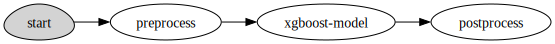

In [6]:
# Set the topology and get the graph object:
graph = test_serving_function.set_topology("flow", engine="async")

# Add the steps:
graph.to(handler="preprocess", name="preprocess") \
     .to("XGBModelServer",
         name="xgboost-model",
         model_path=model_path) \
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
test_serving_function.plot(rankdir='LR')

In [7]:
server = test_serving_function.to_mock_server()

> 2024-02-06 10:06:19,590 [info] model xgboost-model was loaded
> 2024-02-06 10:06:19,926 [error] Pushing error to error stream: Expected key "inputs" in request body
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/storey/flow.py", line 212, in _do_and_recover
    return await self._do(event)
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/storey/flow.py", line 423, in _do
    fn_result = await self._call(element)
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/storey/flow.py", line 410, in _call
    res = self._fn(element)
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/serving/v2_serving.py", line 242, in do_event
    request = self._pre_event_processing_actions(event, event_body, op)
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/serving/v2_serving.py", line 225, in _pre_event_processing_actions
  

In [8]:
import pandas as pd
data = pd.read_csv(
    "financial_transactions_mini.csv",
    parse_dates=["timestamp"],
    infer_datetime_format=True,
    dtype={"transaction_category": "string"},
)

In [9]:
data['transaction_id'] = data.reset_index().index

In [10]:
first_event_data =  data.drop('transaction_category',axis=1)[:1].to_dict('records')
first_event_data

[{'receiver_id': 4518551904499919,
  'sender_id': 4333582346477646,
  'amount': 833.26,
  'timestamp': Timestamp('2021-03-10 19:57:42'),
  'transaction_id': 0}]

In [11]:
response = server.test(body=first_event_data)

> 2024-02-06 10:06:19,928 [error] run error, Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/serving/server.py", line 280, in run
    response = self.graph.run(event, **(extra_args or {}))
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/serving/states.py", line 1147, in run
    return resp.await_result()
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/storey/sources.py", line 67, in await_result
    raise copy.copy(result)
Exception: Expected key "inputs" in request body



RuntimeError: failed (400): Exception: Expected key "inputs" in request body

In [ ]:
print(response)